In [103]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [104]:
rh = RoundHill()
X = rh.experiments[0].X
Y = rh.experiments[0].Y
boundary = proposeboundary(X)
boundary[0][2]=-30 #puts the source on the grid!

In [105]:
#windvect = [rh.experiments[0].windX,rh.experiments[0].windY]
#print(windvect)

In [106]:
len(X)

351

In [107]:
#import random
#keep = random.sample(range(len(X)),50)
#X = X[keep,:]
#Y = Y[keep]

In [108]:
np.set_printoptions(precision=1,suppress=True)

In [109]:
np.array(boundary[1])-np.array(boundary[0])

array([720., 254., 248.])

(-198.7, 80.7, -42.4, 230.4)

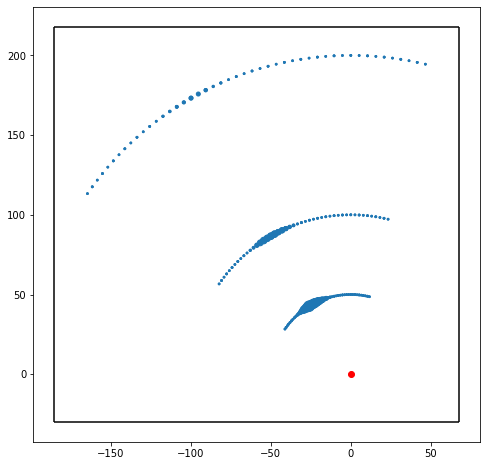

In [110]:
plt.figure(figsize=[8,8])
plt.scatter(X[:,2],X[:,3],3+Y/10)
plt.hlines([boundary[0][2],boundary[1][2]],boundary[0][1],boundary[1][1])
plt.vlines([boundary[0][1],boundary[1][1]],boundary[0][2],boundary[1][2])
plt.plot([0],[0],'or')
plt.axis('equal')

In [111]:
Y /= np.max(Y)

(array([293.,  16.,  13.,   9.,   8.,   6.,   1.,   4.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

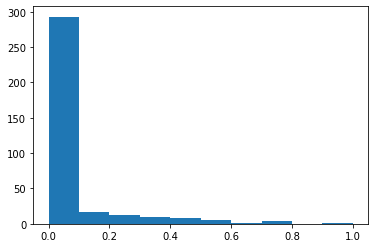

In [112]:
plt.hist(Y)

In [194]:
#set up our model...
N_feat = 80 #Number of features used to infer the source
k = EQ(20, 1)
res = [80,30,30]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
print("Memory usage in grid model: %0.2f Gb" % gbs)
assert gbs<6, "TOO BIG :("
noiseSD = 0.01
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(rh.experiments[0].windX/1000,rh.experiments[0].windY/1000)
k_0 = 0.01
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference


Memory usage in grid model: 0.19 Gb


In [195]:
#dt: time grid size
#dx: x direction grid size
#dy: y direction grid size
#dx2 = dx**2
#dy2 = dy**2
#Nt: Number of evaluation points in time
#Nx: Number of evaluation points in x axis
#Ny: Number of evaluation points in y axis
mInfer.getGridStepSize()

(9.0,
 8.466666666666667,
 8.266666666666667,
 71.68444444444445,
 68.33777777777779,
 80,
 30,
 30)

In [196]:
mInfer.computeModelRegressors(Nparticles=10) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...


In [197]:
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

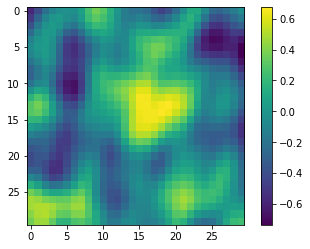

In [198]:
plt.imshow(concInfer[4,:,:])
plt.colorbar()

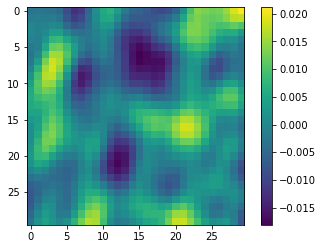

In [199]:
plt.imshow(sourceInfer[4,:,:])
plt.colorbar()

In [200]:
boundary

([-60.0, -186.0, -30], [660.0, 68.0, 218.0])

In [201]:
tgrid = []
ts = np.unique(X[:,1])
for t in np.unique(X[:,1]):
    tgrid.append(mInfer.getGridCoord([t,0,0])[0])
tgrid

[10, 26, 73]

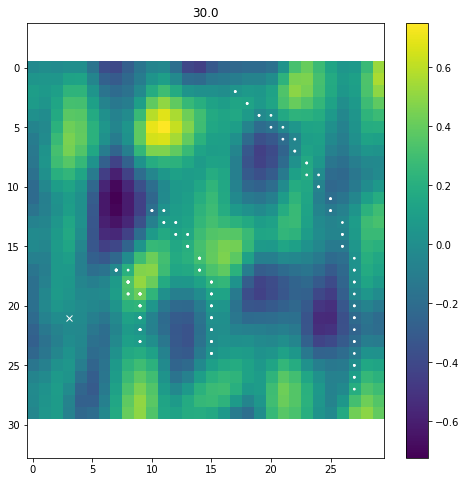

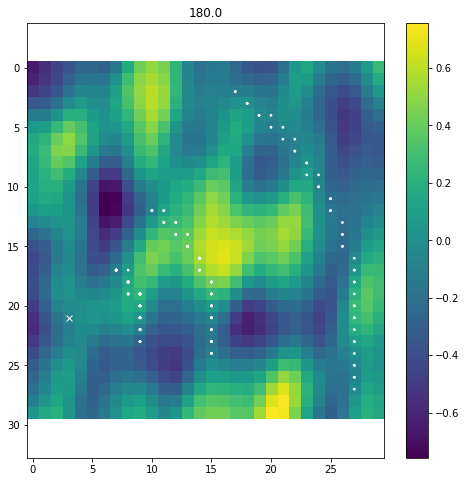

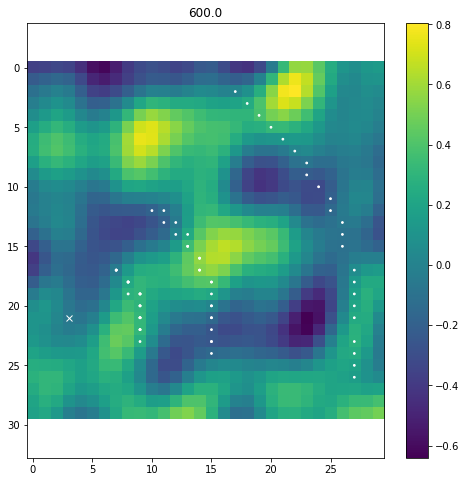

In [202]:
realsource = mInfer.getGridCoord([0,0,0])
Xgrid = mInfer.getGridCoord(X[:,[0,2,3]])
for t,tg in zip(ts,tgrid):#range(5,40,5):
    plt.figure(figsize=[8,8])

    #plt.imshow(sourceInfer[tg,:,:])
    plt.imshow(concInfer[tg,:,:])
    plt.colorbar()
    plt.title(t)
    plt.plot(realsource[2],realsource[1],'xw')
    plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t],color='w')
    plt.axis('equal')

(array([293.,  16.,  13.,   9.,   8.,   6.,   1.,   4.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

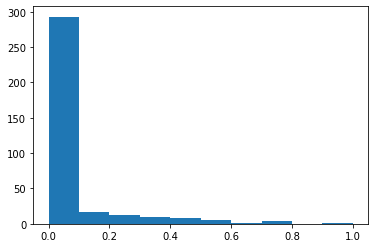

In [203]:
plt.hist(Y)

In [204]:
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

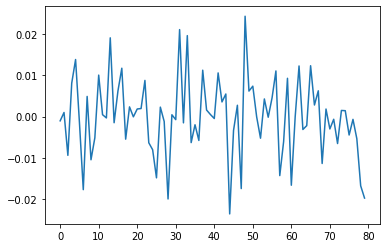

In [205]:
plt.plot(meanZ)

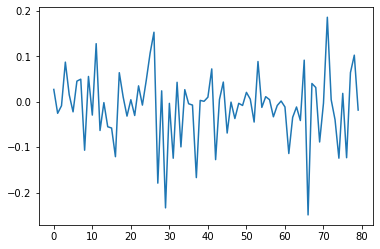

In [206]:
plt.plot(z_samp)

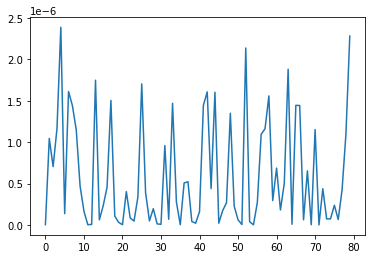

In [207]:
plt.plot(np.diag(covZ))

In [208]:
np.random.multivariate_normal(meanZ,covZ)

array([-0.,  0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
        0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,
        0., -0., -0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.,
        0., -0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0., -0.,
       -0.,  0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,  0., -0., -0.,
        0.,  0.,  0., -0.,  0., -0., -0., -0.,  0.,  0., -0., -0., -0.,
       -0., -0.])

In [209]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,5):
    s = mInfer.computeSourceFromPhi(z_samp)
    source_samples.append(s)
    conc_samples.append(mInfer.computeConcentration(s))
    
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)


(array([  149.,  1049.,  3606., 10357., 19704., 19268., 11820.,  4880.,
         1101.,    66.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

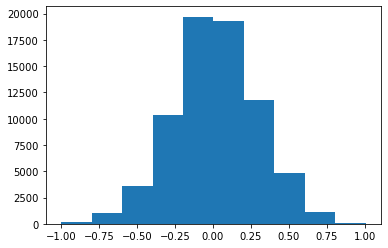

In [210]:
plt.hist(concInfer.flatten())

(array([  144.,  1055.,  3597., 10335., 19724., 19246., 11879.,  4861.,
         1089.,    70.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

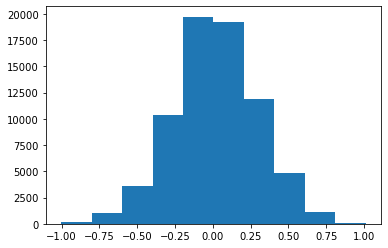

In [211]:
plt.hist(conc_mean.flatten())

In [212]:
mInfer.resolution

array([80, 30, 30])

In [213]:
concInfer[-1,:,:]

array([[-0.4, -0.3, -0.1,  0. ,  0.1, -0.1, -0.4, -0.6, -0.6, -0.4, -0.2,
        -0.1, -0. , -0.1, -0.1, -0. ,  0.1,  0.1,  0. ,  0. ,  0.1,  0.2,
         0.5,  0.6,  0.4,  0.1, -0.1, -0.3, -0.4, -0.3],
       [-0.5, -0.4, -0.2, -0.1, -0.1, -0.3, -0.6, -0.8, -0.7, -0.5, -0.1,
         0.1,  0.2,  0.1,  0.1,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.3,
         0.5,  0.5,  0.3, -0. , -0.3, -0.4, -0.4, -0.3],
       [-0.6, -0.5, -0.3, -0.1, -0.2, -0.4, -0.8, -0.9, -0.7, -0.4,  0. ,
         0.3,  0.4,  0.3,  0.3,  0.3,  0.4,  0.4,  0.4,  0.3,  0.3,  0.4,
         0.5,  0.4,  0.1, -0.2, -0.4, -0.5, -0.4, -0.3],
       [-0.6, -0.5, -0.3, -0.1, -0.2, -0.5, -0.8, -0.9, -0.6, -0.2,  0.2,
         0.5,  0.5,  0.4,  0.4,  0.4,  0.5,  0.5,  0.5,  0.4,  0.4,  0.4,
         0.4,  0.3, -0. , -0.3, -0.5, -0.5, -0.4, -0.2],
       [-0.5, -0.4, -0.2, -0.1, -0.1, -0.4, -0.7, -0.7, -0.5, -0. ,  0.4,
         0.6,  0.5,  0.4,  0.4,  0.4,  0.5,  0.6,  0.6,  0.5,  0.4,  0.4,
         0.3,  0.2, -0.1, -0.3, 

In [214]:
conc_mean[-1,:,:]

array([[-0.4, -0.3, -0.1,  0. ,  0.1, -0.1, -0.4, -0.6, -0.6, -0.4, -0.2,
        -0.1, -0. , -0.1, -0.1, -0. ,  0.1,  0.1,  0. ,  0. ,  0.1,  0.3,
         0.5,  0.6,  0.5,  0.2, -0.1, -0.3, -0.4, -0.3],
       [-0.5, -0.4, -0.2, -0.1, -0.1, -0.3, -0.6, -0.8, -0.7, -0.5, -0.1,
         0.1,  0.2,  0.1,  0.1,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.3,
         0.5,  0.5,  0.3, -0. , -0.3, -0.4, -0.4, -0.3],
       [-0.6, -0.5, -0.3, -0.2, -0.2, -0.4, -0.8, -0.9, -0.7, -0.4,  0. ,
         0.3,  0.4,  0.3,  0.3,  0.3,  0.4,  0.4,  0.4,  0.3,  0.3,  0.4,
         0.5,  0.4,  0.1, -0.2, -0.4, -0.5, -0.4, -0.3],
       [-0.6, -0.5, -0.3, -0.2, -0.2, -0.5, -0.8, -0.9, -0.6, -0.2,  0.2,
         0.5,  0.5,  0.4,  0.4,  0.4,  0.5,  0.5,  0.5,  0.4,  0.4,  0.4,
         0.4,  0.3, -0. , -0.3, -0.4, -0.5, -0.4, -0.2],
       [-0.5, -0.4, -0.2, -0.1, -0.2, -0.5, -0.7, -0.7, -0.5, -0. ,  0.4,
         0.6,  0.5,  0.4,  0.3,  0.4,  0.5,  0.6,  0.6,  0.5,  0.4,  0.4,
         0.3,  0.2, -0.1, -0.3, 

(-0.5, 29.5, 29.5, -0.5)

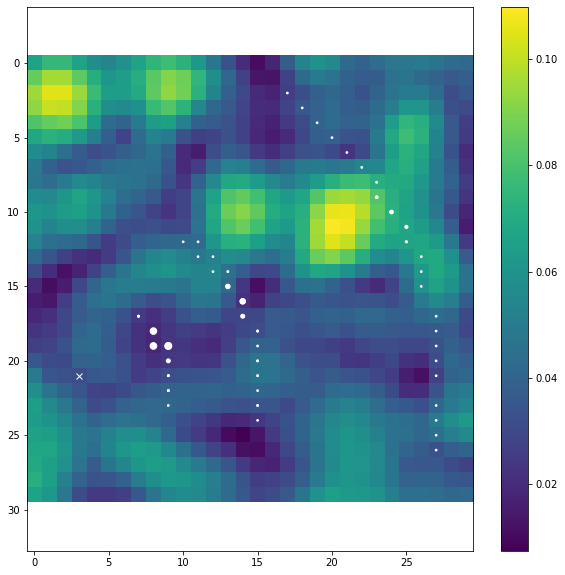

In [215]:
plt.figure(figsize=[10,10])
plt.imshow((conc_upper_ci-conc_lower_ci)[tgrid[2],:,:])
plt.colorbar()
plt.plot(realsource[2],realsource[1],'xw')
plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*100,color='w')
plt.axis('equal')


In [216]:
conf

array([[4.8, 5.5, 6.3, 6.2, 4.9, 2.7, 2.3, 4.2, 5.6, 5.8, 5.2, 4.2, 3.4,
        3.4, 3.7, 4.7, 5.4, 5.4, 4.3, 2.8, 2.7, 3.4, 4.1, 4.5, 4.3, 3.9,
        3.2, 2.1, 2.5, 3.1],
       [4.1, 4.9, 6.9, 7.1, 5.6, 3.8, 1.4, 3.6, 5.8, 6.1, 4.6, 3.4, 3.1,
        4. , 4.4, 4.6, 4.9, 4.9, 3.4, 1.7, 1.9, 3. , 3.8, 4.4, 4.6, 4.2,
        3.3, 2.4, 3. , 3.3],
       [4.3, 6. , 7.5, 7.4, 5.9, 4.1, 2.1, 4.2, 5.6, 5.4, 4.3, 2.9, 3.2,
        4.5, 5.5, 6.2, 5.9, 5.2, 3.4, 2. , 3.1, 3.5, 2.9, 3. , 3.7, 3.5,
        2.9, 2.3, 2.6, 2.5],
       [4.9, 6.4, 7.3, 6.8, 5.2, 3.4, 3.5, 5.4, 6.2, 5.3, 3.4, 1.8, 3.3,
        4.3, 5.2, 6.9, 7. , 6. , 4. , 2.6, 3.2, 3.1, 2. , 2. , 2.8, 2.7,
        1.9, 2. , 1.9, 1.6],
       [4.2, 5.5, 6. , 5.3, 3.9, 3.9, 4.8, 6.4, 6.6, 5.1, 2.2, 1.6, 3.1,
        4.6, 6.1, 7.9, 7.7, 6.1, 4.3, 2.7, 2.5, 2.6, 3.4, 4. , 3.8, 2.3,
        1.1, 2. , 2.3, 1.9],
       [2.2, 3.4, 4. , 3.8, 3.8, 5. , 6.8, 7.8, 6.9, 4.5, 1.9, 2.6, 3.8,
        5.3, 7.1, 8.4, 7.8, 5.8, 4.2, 2.5, 1.7, 2.8,

In [217]:
conf = (conc_upper_ci-conc_lower_ci)[tgrid[2],:,:]
conc = concInfer[tg,:,:].copy()
conc[conf>200]=np.NaN

(-0.5, 29.5, 29.5, -0.5)

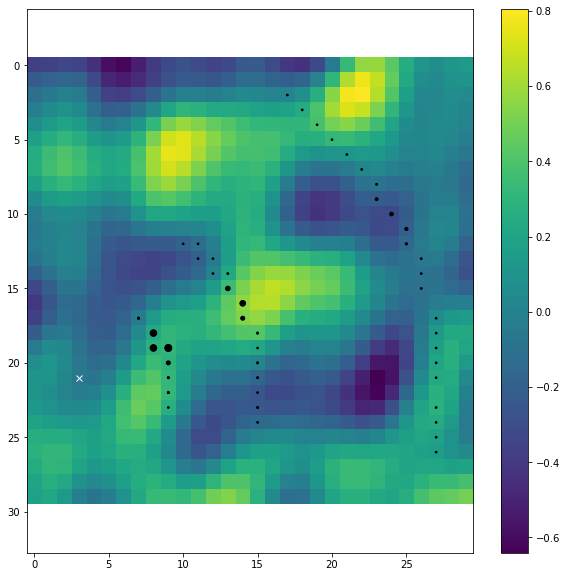

In [218]:
plt.figure(figsize=[10,10])
plt.imshow(conc)
plt.colorbar()
plt.plot(realsource[2],realsource[1],'xw')
plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*100,color='k')
plt.axis('equal')
